In this kernal, I am generating sample images of Simpsons with deep convolutional generative adversarial networks (DCGANs). 
The code is implemented using Keras.
The approach is inspired from:
https://www.kaggle.com/greg115/image-generator-dcgan-the-simpsons-dataset (The code is implemented using Tensorflow and I change it to fully uses Keras)

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython import display
from tensorflow.keras import layers, datasets
import os
import imageio
import shutil
import time
from PIL import Image
from keras.initializers import RandomNormal, TruncatedNormal
import random
from glob import glob

In [0]:
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D , Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Hyperparameters
IMAGE_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 10 # For better results increase this value
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 8

In [0]:
# Create Generator
def get_generator(z=(NOISE_SIZE,)):
    # 4 x 4 x 512
    input_layer = Input(z)
    hid = Dense(4*4*512, activation='relu', name ="Dense")(input_layer)    
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Reshape((4, 4, 512))(hid)

    # 4x4x512 -> 8x8x512
    hid = Conv2DTranspose(512, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv1")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv1")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv1_out")(hid)
    

    # 8x8x512 -> 16x16x256
    hid = Conv2DTranspose(256, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv2")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv2")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv2_out")(hid)
    
    
    # 16x16x256 -> 32x32x128
    hid = Conv2DTranspose(128, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv3")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv3")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv3_out")(hid)    
    

    # 32x32x128 -> 64x64x64
    hid = Conv2DTranspose(64, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv4")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv4")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv4_out")(hid)        
    

    # 64x64x64 -> 64x64x3
    hid = Conv2DTranspose(3, kernel_size=[5,5],
                               strides=[1,1],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="logits")(hid)
  
    out = Activation("tanh", name ="out")(hid)
    
    model = Model(inputs=input_layer, outputs=out)
    model.summary()
  
    return model


In [0]:
# Create Discriminator

def get_discriminator(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)):
    # 64x64x3 -> 32x32x32
    input_layer = Input(input_shape)
    hid = Conv2D(filters=32,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv1")(input_layer)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm1")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv1_out")(hid)    
    
    # 32x32x32-> 16x16x64 
    hid = Conv2D(filters=64,
                        kernel_size=[5,5],
                        strides=[2,2],
                        padding="same",
                        kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                        name = "conv2")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm2")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv2_out")(hid) 
    
    # 16x16x64  -> 8x8x128  
    hid = Conv2D(filters=128,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv3")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm3")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv3_out")(hid)
    
    # 8x8x128 -> 8x8x256
    hid = Conv2D(filters=256,
                    kernel_size=[5,5],
                    strides=[1,1],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv4")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm4")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv4_out")(hid)
    

    # 8x8x256 -> 4x4x512
    hid = Conv2D(filters=512,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv5")(hid)  
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm5")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv5_out")(hid)
    
    hid = Flatten(name = "flatten")(hid)

    out = Dense(1, activation='sigmoid', name = "ligit")(hid)
    model = Model(inputs= input_layer, outputs=out)

    model.summary()

    return model

In [0]:
#Discriminator
discriminator = get_discriminator((IMAGE_SIZE, IMAGE_SIZE,3))
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(lr=LR_D, beta_1=BETA1),metrics=['accuracy'])

# For the combined model we will only train the generator
discriminator.trainable = False

#Generator
generator = get_generator((NOISE_SIZE,))

#GAN
# The discriminator takes generated images as input and determines validity
gan_input = Input(shape=(NOISE_SIZE,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(loss='binary_crossentropy',optimizer=Adam(lr=LR_G, beta_1=BETA1))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_out (LeakyReLU)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 16, 16, 64)        256       
_________________________________________________________________
conv2_out (LeakyReLU)        (None, 16, 16, 64)        0   

In [0]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        #image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    #plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [0]:
def test(input_z, epoch):
    samples = generator.predict(input_z[:SAMPLES_TO_SHOW])
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)

In [0]:
def summarize_epoch(d_losses, g_losses , data_shape, epoch, duration, input_z):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(input_z, epoch)

In [0]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([False, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return np.array(batches)

In [0]:
# Paths
from google.colab import drive
drive.mount('/content/drive')

!tar -xvf drive/My\ Drive/Colab\ Notebooks/data/simpson_faces.tar.gz -C /content/

INPUT_DATA_DIR = '/content/cropped/' # Path to the folder with input images. For more info check simspons_dataset.txt
#OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
#if not os.path.exists(OUTPUT_DIR):
 #   os.makedirs(OUTPUT_DIR)
OUTPUT_DIR =""
    

Image Samples
Input: (9877, 64, 64, 3)


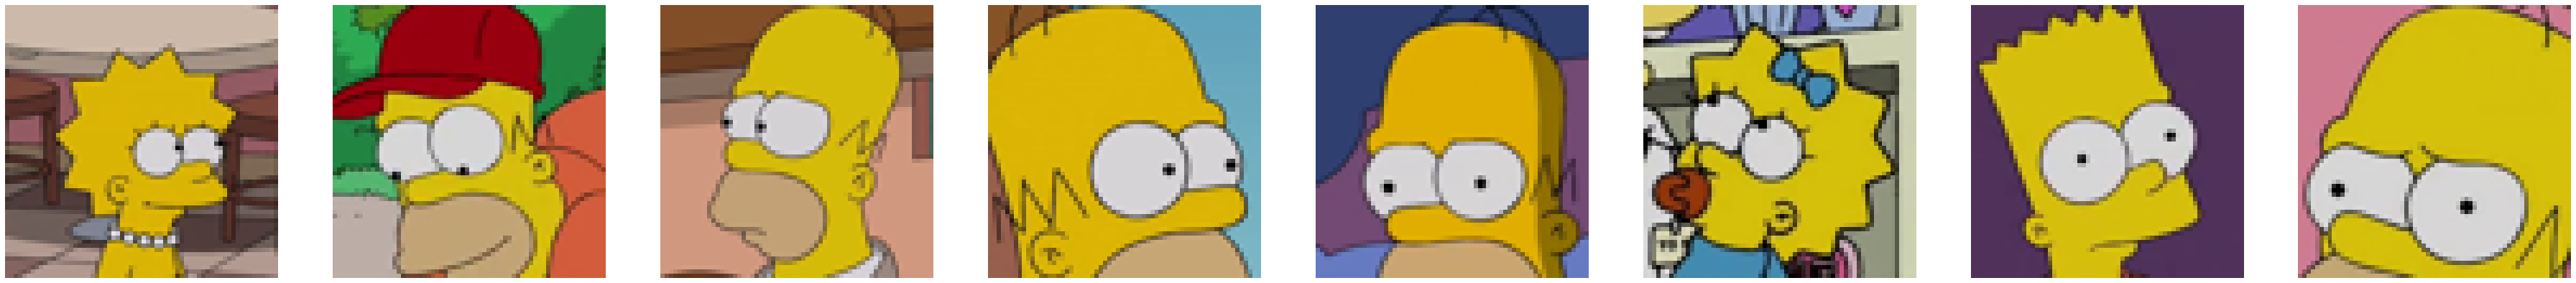

In [0]:
# Import Data
import re

exclude_img = ["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
"1702","1281","1272","772","736","737","691","684","314","242","191"]

exclude_img = [s + ".png" for s in exclude_img]

print("Image Samples")
#input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*') if file not in exclude_img])

print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

Training Starts!
Epoch 1/10 
Duration: 27.54351 
D Loss: 0.84390 
G Loss: 0.72091


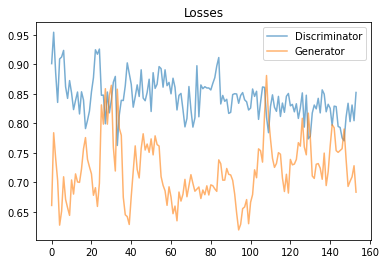

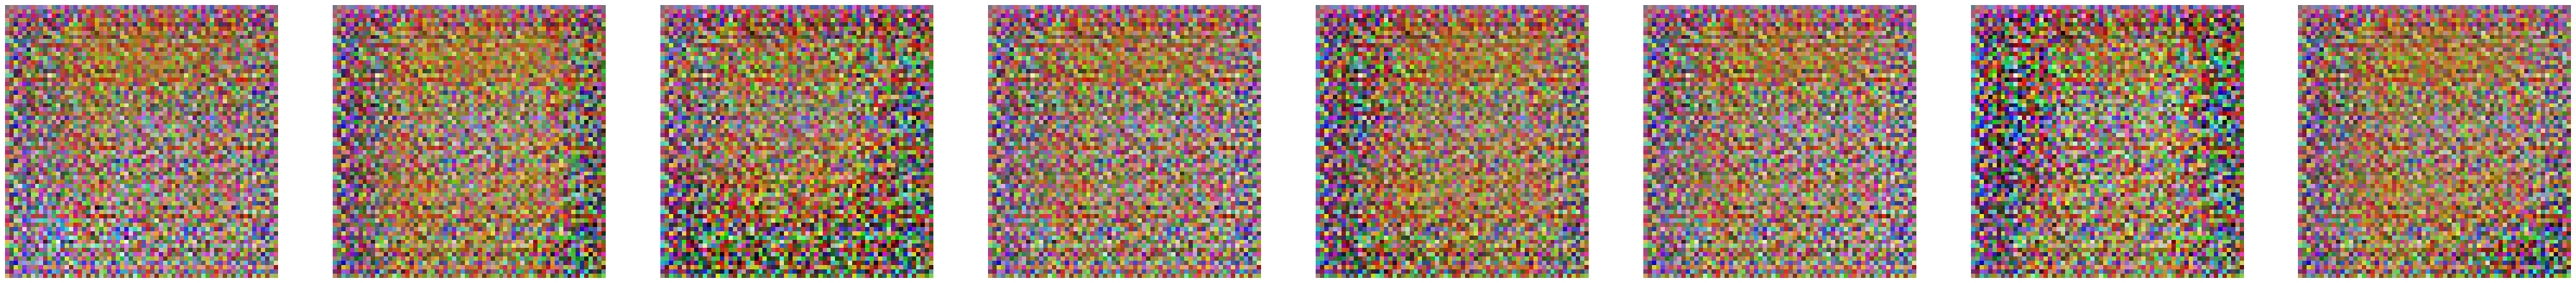

Epoch 2/10 
Duration: 27.67389 
D Loss: 0.75669 
G Loss: 0.78931


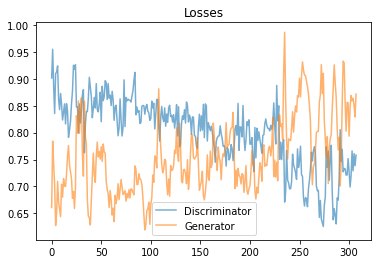

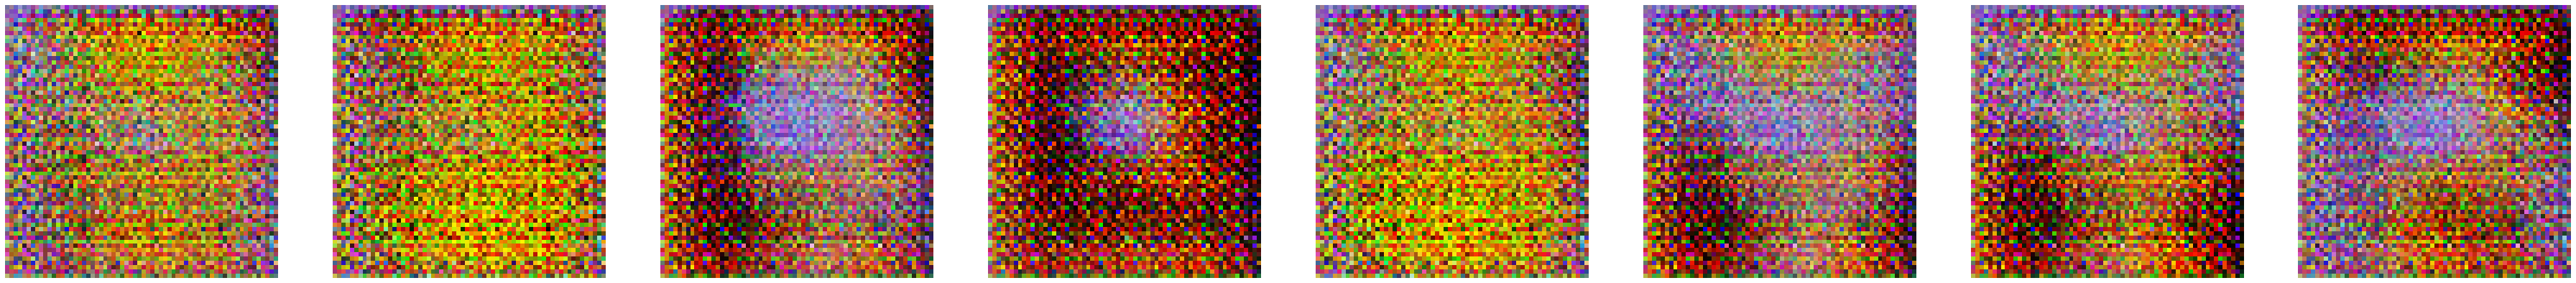

Epoch 3/10 
Duration: 27.54727 
D Loss: 0.70629 
G Loss: 0.82791


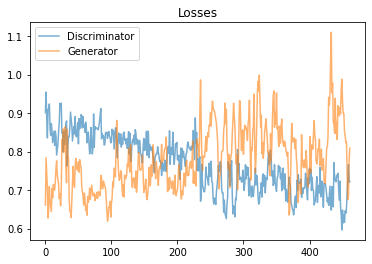

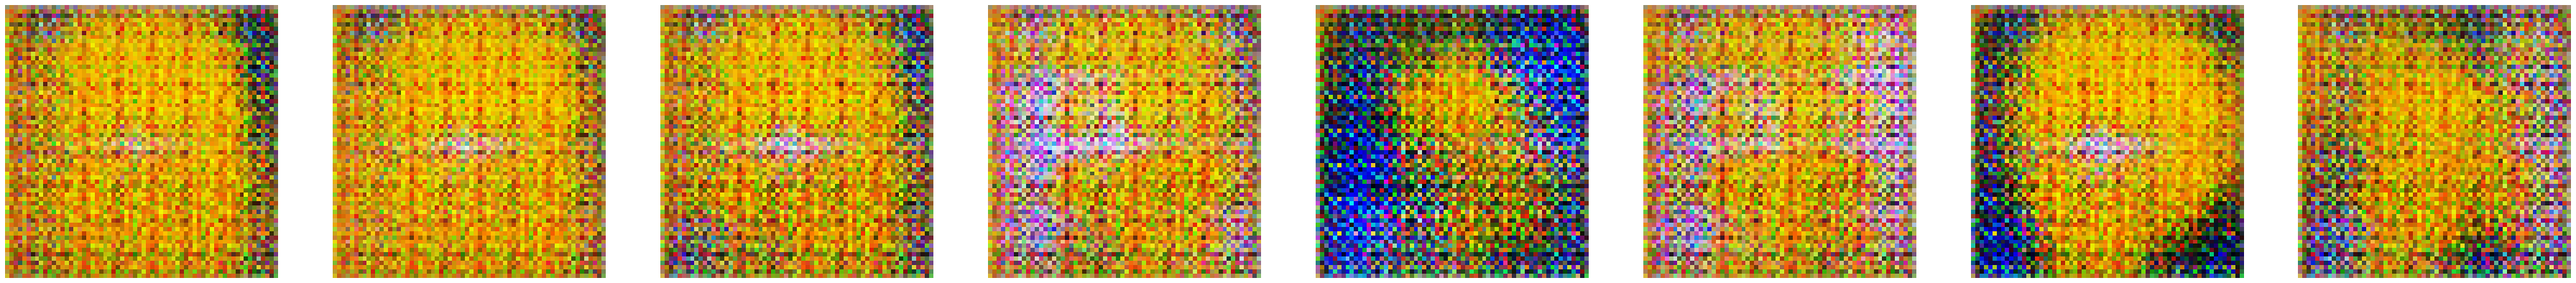

Epoch 4/10 
Duration: 27.89354 
D Loss: 0.75053 
G Loss: 0.78703


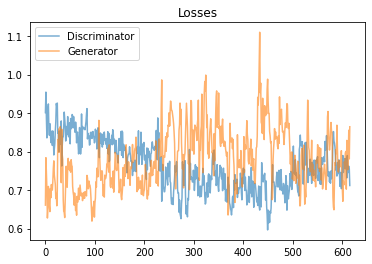

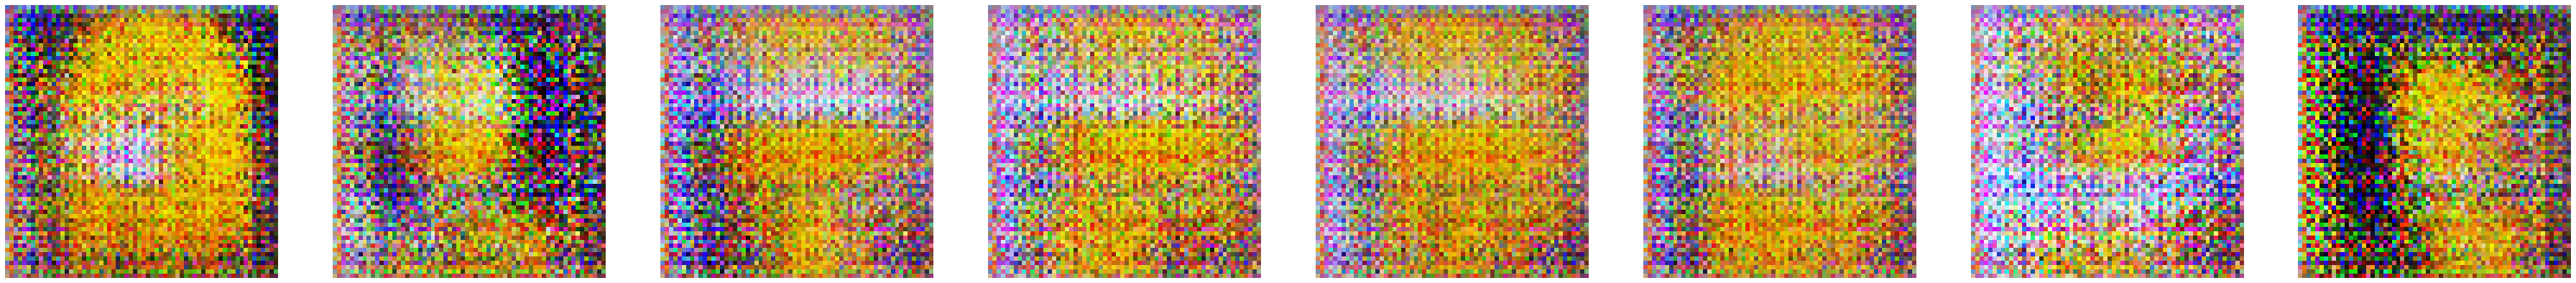

Epoch 5/10 
Duration: 27.57940 
D Loss: 0.76340 
G Loss: 0.73952


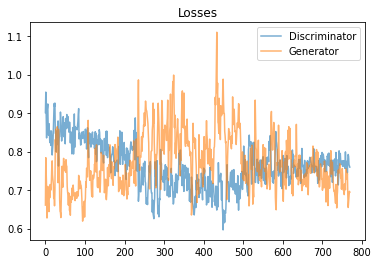

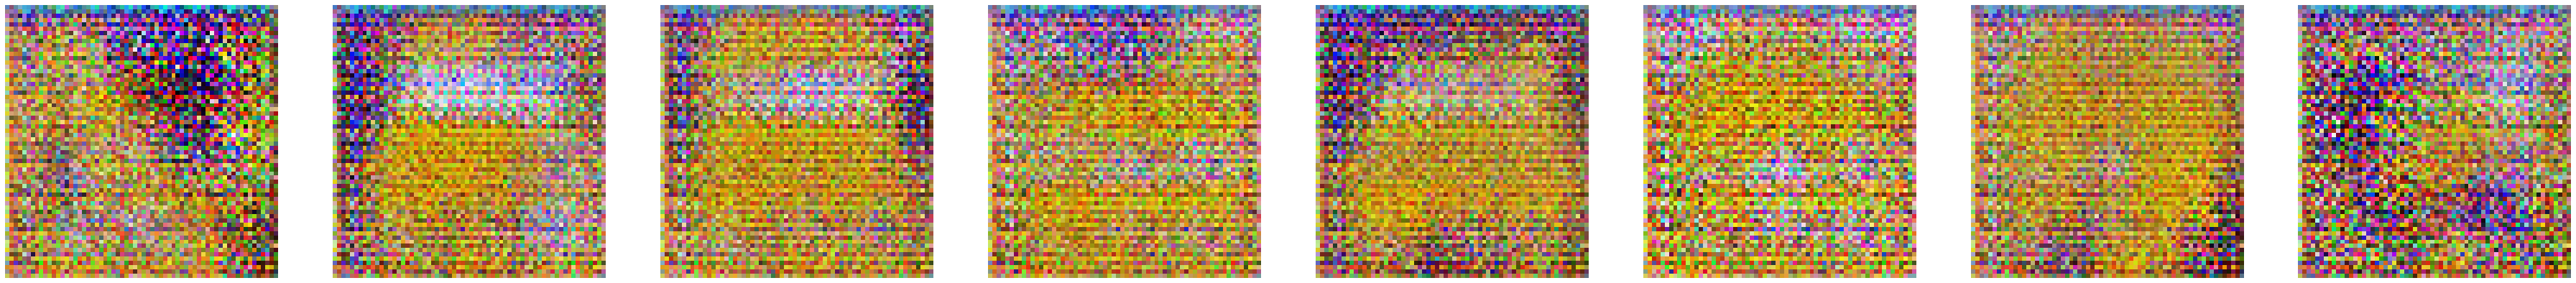

Epoch 6/10 
Duration: 27.79037 
D Loss: 0.75869 
G Loss: 0.72424


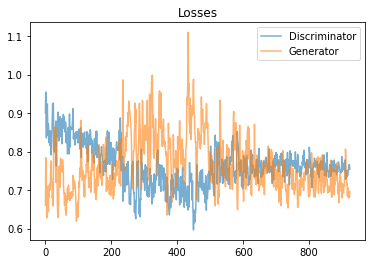

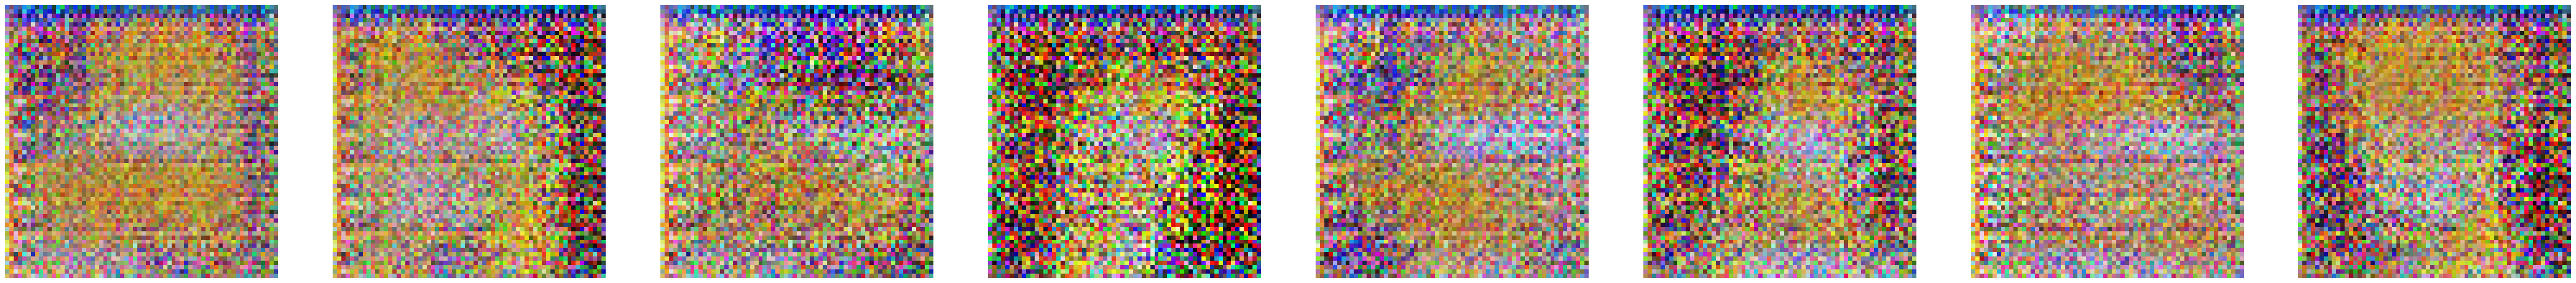

Epoch 7/10 
Duration: 27.59318 
D Loss: 0.75325 
G Loss: 0.72103


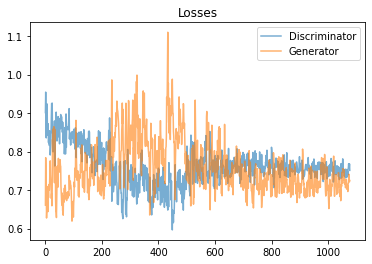

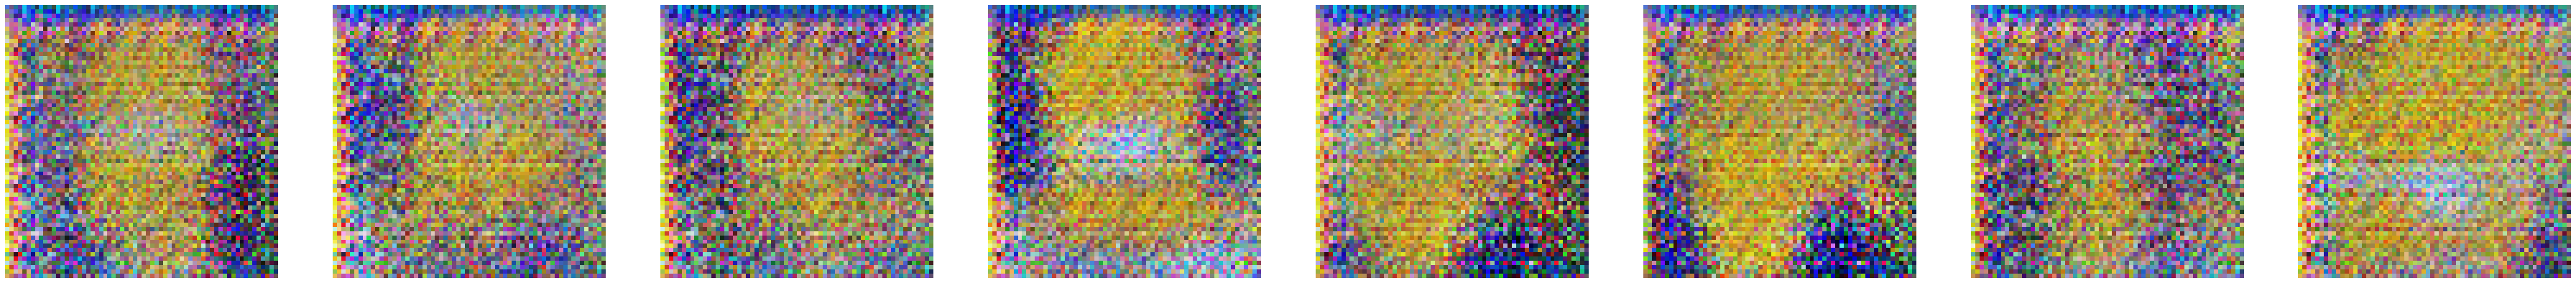

Epoch 8/10 
Duration: 27.62114 
D Loss: 0.74124 
G Loss: 0.72882


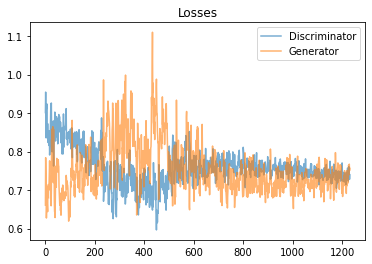

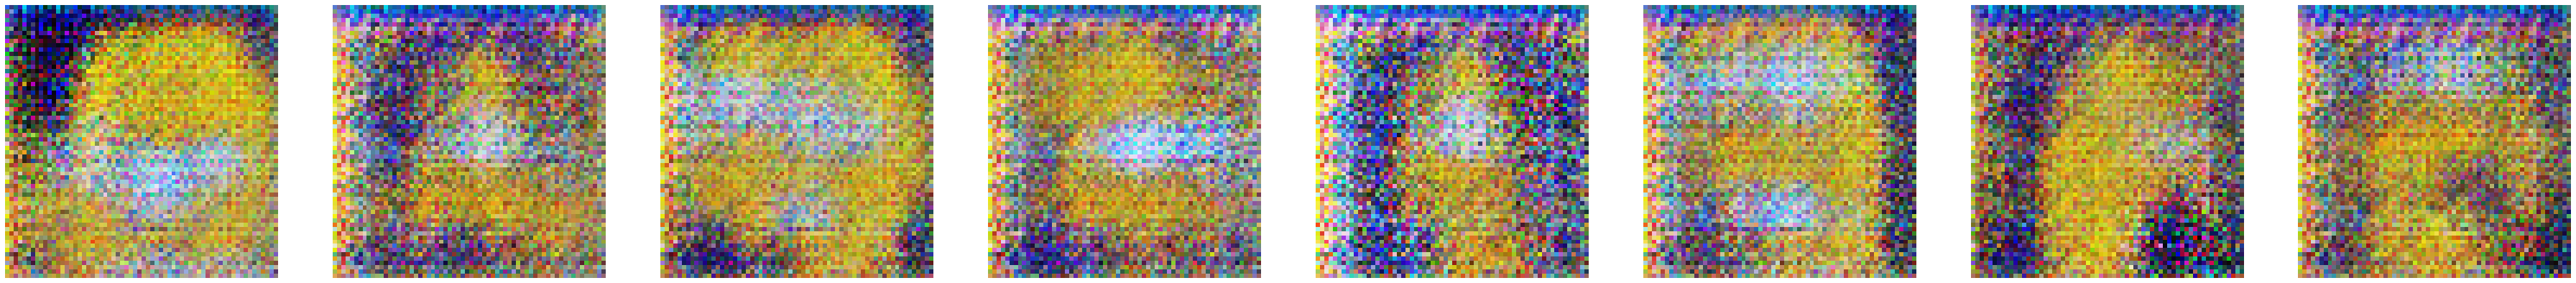

Epoch 9/10 
Duration: 27.67405 
D Loss: 0.73233 
G Loss: 0.73673


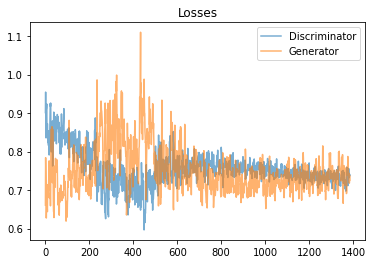

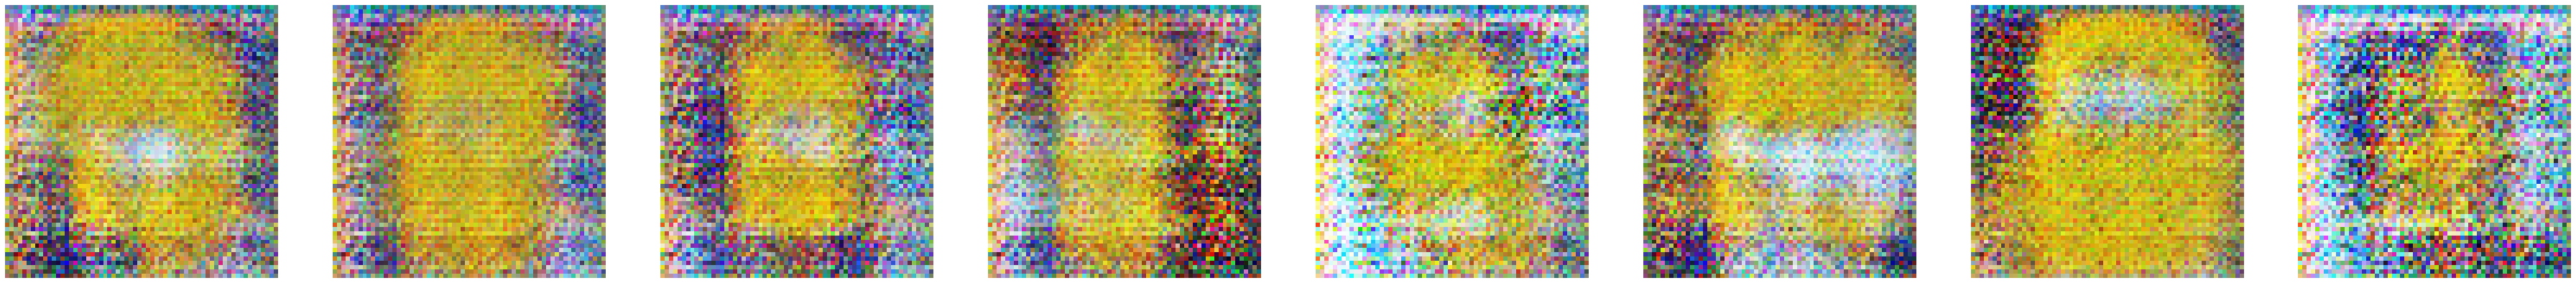

Epoch 10/10 
Duration: 27.67032 
D Loss: 0.72958 
G Loss: 0.74283


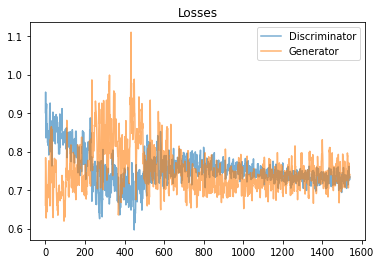

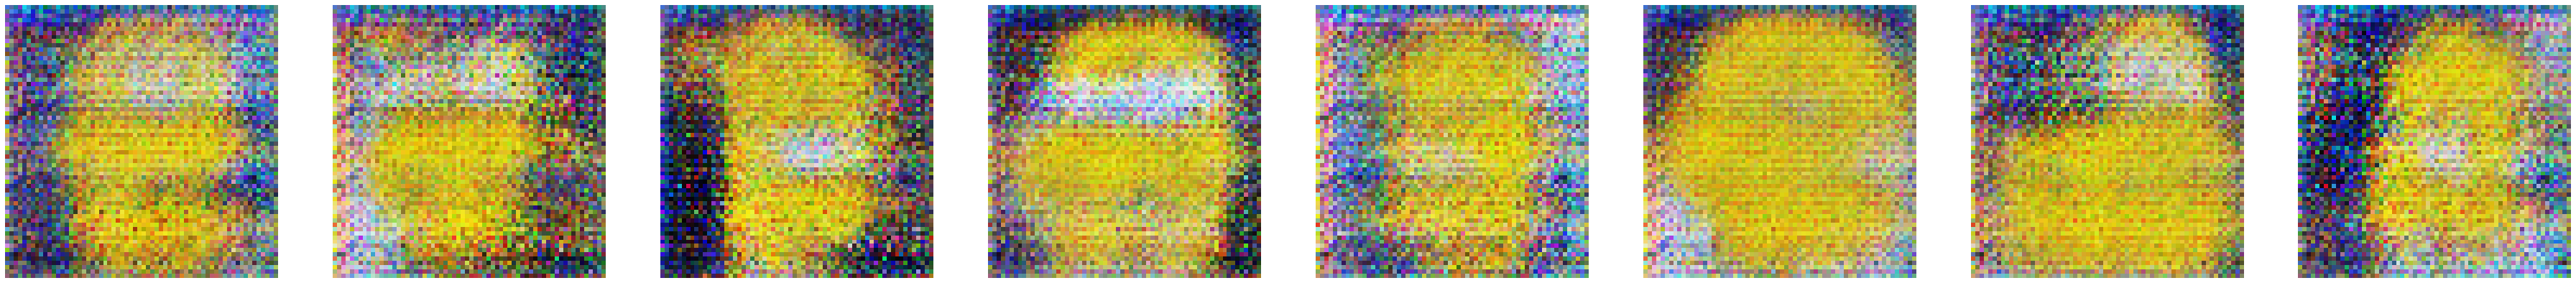

In [0]:
# Training
print("Training Starts!")

warnings.filterwarnings("ignore")

d_losses = []
g_losses = []
cum_d_loss = 0
cum_g_loss = 0

#EPOCHS = 50
for epoch in range(EPOCHS):
    epoch += 1
    start_time = time.time()
    
    for batch_images in get_batches(input_images):
        
        noise_data = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_SIZE))
        # We use same labels for generated images as in the real training batch
        generated_images = generator.predict(noise_data)
        
        noise_prop = 0#0.05 # Randomly flip 5% of targets
        real_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(real_labels)), size=int(noise_prop*len(real_labels)))
        real_labels[flipped_idx] = 1 - real_labels[flipped_idx]
        
        # Train discriminator on real data
        d_loss_real = discriminator.train_on_batch(batch_images, real_labels)


        # Prepare labels for generated data
        fake_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(fake_labels)), size=int(noise_prop*len(fake_labels)))
        fake_labels[flipped_idx] = 1 - fake_labels[flipped_idx]
        
        # Train discriminator on generated data
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        cum_d_loss += d_loss
        d_losses.append(d_loss[0])
        
        
        # Train generator
        noise_data = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_SIZE))
        g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
        cum_g_loss += g_loss
        g_losses.append(g_loss)
        
    if epoch > 0 and epoch % 20 == 0 :
        print("saving model")
        discriminator.save_weights("desc-simposon-model.h5-" + str(epoch))
        gan.save_weights("gan-simposon-model.h5-" + str(epoch))
        
    # Plot the progress
    summarize_epoch(d_losses, g_losses, input_images.shape, epoch, time.time()-start_time, noise_data)


In [0]:
#Load Weights if crash
#discriminator.load_weights("desc-simposon-model.h5-40")
#gan.load_weights("gan-simposon-model.h5-40")